# Laboratorio 1 - Aprendizaje de Máquina
Sergio Ferreira - Juan David Gutierrez


- [Carga de datos](#carga-de-datos)
- [Limpieza de datos](#limpieza-de-datos)
    - [Transformación de variables categóricas](#2_1)
    - [Valores atípicos](#2_2)
- [Transformación de los datos](#3)
    - [Completitud e Imputación](#3_1)
    - [Multicolinealidad](#multicolinealidad)
    - [Correlación con la variable objetivo](#3_3)
    - [Escalado de los datos](#escalado-de-los-datos)


---
### Librerías utilizadas

In [565]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

---
### Carga de datos

In [566]:
data = pd.read_csv('data/Datos Lab 1.csv')
data.info()
data.sample(3)

<class 'pandas.DataFrame'>
RangeIndex: 1639 entries, 0 to 1638
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Patient ID                    1639 non-null   str    
 1   Date of Service               1639 non-null   str    
 2   Sex                           1639 non-null   str    
 3   Age                           1571 non-null   float64
 4   Weight (kg)                   1566 non-null   float64
 5   Height (m)                    1578 non-null   float64
 6   BMI                           1586 non-null   float64
 7   Abdominal Circumference (cm)  1578 non-null   float64
 8   Blood Pressure (mmHg)         1639 non-null   str    
 9   Total Cholesterol (mg/dL)     1571 non-null   float64
 10  HDL (mg/dL)                   1557 non-null   float64
 11  Fasting Blood Sugar (mg/dL)   1585 non-null   float64
 12  Smoking Status                1639 non-null   str    
 13  Diabetes Statu

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
617,ZEFR1505,10-27-2022,F,28.0,88.954,1.877,32.025,74.764,139/98,268.0,...,High,Y,187.748,NaN,139.0,NaN,Hypertension Stage 1,184.0,18.715,HIGH
715,ZJNt4248,13 Jul 21,M,53.0,51.500,1.850,15.000,NaN,108/61,167.0,...,Low,Y,185.000,0.593,108.0,61.0,Normal,87.0,11.740,INTERMEDIARY
68,tCaB2910,2025-02-23,M,35.0,87.700,1.860,25.300,87.900,135/91,253.0,...,High,Y,186.000,0.473,135.0,91.0,Hypertension Stage 1,149.0,16.870,HIGH


---
## Limpieza de datos
### Pacientes duplicados
Inicialmente vamos a verificar si existen pacientes duplicados y de existir guardar únicamente la entrada más reciente

In [567]:
dup_counts = (data['Patient ID'].value_counts()
                        .loc[lambda s: s > 1]
                        .sort_values(ascending=False))
print(len(dup_counts))

171


Para poder comparar las fechas de servicio en la columna *Date of Service* vamos a estandarizar las fechas, pues están con formatos mezclados, para esto utilizaremos la función `to_datetime` de la librería `pandas`

In [568]:
data['Date of Service'] = pd.to_datetime(data['Date of Service'], format='mixed')
data.sample(5)

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
663,QygN1471,2020-08-28,M,49.0,62.814,1.836,23.749,98.415,150/81,254.0,...,Low,Y,183.640,0.536,150.0,81.000,Hypertension Stage 1,180.0,19.330,HIGH
1348,hArt5191,2023-06-18,M,50.0,83.000,1.850,24.300,91.700,141/78,279.0,...,Low,N,NaN,0.496,141.0,78.000,Hypertension Stage 2,190.0,19.490,HIGH
1550,VUBY0625,2025-08-10,F,31.0,61.393,1.630,22.696,111.024,154/112,164.0,...,Moderate,N,163.023,0.681,154.0,112.000,Hypertension Stage 2,49.0,15.519,HIGH
1356,dSiv4949,2022-03-10,F,46.0,76.100,1.880,21.500,98.200,98/90,149.0,...,Low,Y,188.000,0.522,98.0,90.000,Hypertension Stage 2,55.0,12.180,HIGH
570,qZzL2192,2024-06-04,M,30.0,78.500,1.770,25.100,100.600,131/79,162.0,...,Low,Y,177.000,0.568,131.0,35.243,Hypertension Stage 1,90.0,14.810,HIGH


Cómo se observa ahora todas las fechas mantienen el formato `YYYY-MM-DD`, así que podemos eliminar los registros duplicados de un paciente

In [569]:
data = data.sort_values(['Patient ID', 'Date of Service'], ascending=[True, False])
data = data.drop_duplicates(subset='Patient ID', keep='first')
data.info()

<class 'pandas.DataFrame'>
Index: 1376 entries, 675 to 799
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Patient ID                    1376 non-null   str           
 1   Date of Service               1376 non-null   datetime64[us]
 2   Sex                           1376 non-null   str           
 3   Age                           1317 non-null   float64       
 4   Weight (kg)                   1313 non-null   float64       
 5   Height (m)                    1327 non-null   float64       
 6   BMI                           1332 non-null   float64       
 7   Abdominal Circumference (cm)  1327 non-null   float64       
 8   Blood Pressure (mmHg)         1376 non-null   str           
 9   Total Cholesterol (mg/dL)     1319 non-null   float64       
 10  HDL (mg/dL)                   1310 non-null   float64       
 11  Fasting Blood Sugar (mg/dL)   1329 non-null  

<a id="2_1"></a>
### Transformación de variables categóricas

Ahora nos enfocaremos en convertir los descriptores con variables categóricas a variables numéricas, vital para la predicción basada en regresión, las variables a transformar son:
* Sex
* Blood Pressure
* Smoking Status
* Diabetes Status
* Physical Activity Level
* Family History of CVD
* Blood Pressure Category

En este punto transformaremos las variables *Sex*, *Smoking Status*, *Diabetes Status* y *Family History of CVD* que pueden transformarse a variables binarias, por convención tomaremos los valores `Y` y `F` (en el caso de *Sex*) como 1 y los valores `N` y `M` como 0. 

In [570]:
encoder_NY = OrdinalEncoder(categories=[['N', 'Y']])
encoder_MF = OrdinalEncoder(categories=[['M', 'F']])
data['Smoking Status'] = encoder_NY.fit_transform(data[['Smoking Status']]).astype(int)
data['Diabetes Status'] = encoder_NY.fit_transform(data[['Diabetes Status']]).astype(int)
data['Family History of CVD'] = encoder_NY.fit_transform(data[['Family History of CVD']]).astype(int)
data['Sex'] = encoder_MF.fit_transform(data[['Sex']]).astype(int)

Continuamos transformando las variables ordinales *Physical Activity Level*, *Blood Pressure Category* y *CVD Risk Level* usando una codificación ordinal

In [571]:
encoder_PAL = OrdinalEncoder(categories=[['Low', 'Moderate', 'High']])
encoder_BPC = OrdinalEncoder(categories=[['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2']])
data['Physical Activity Level'] = encoder_PAL.fit_transform(data[['Physical Activity Level']]).astype(int)
data['Blood Pressure Category'] = encoder_BPC.fit_transform(data[['Blood Pressure Category']]).astype(int)

Por último vamos a redondear la edad y el HDL al número entero más cercano para manejar una mejor escala.

In [572]:
data['Age'] = data['Age'].dropna().round().astype(int)

### Eliminación de variables redundantes

Finalmente, debemos codificar la variable *Blood Pressure* la cual está reportada con dos valores en columnas adicionales que separan estos valores en *Systolic BP* y *Diastolic BP*, por lo que esta columna no presenta información nueva y puede ser eliminada. 

Adicionalmente, existen otras columnas que pueden ser eliminadas ya que no tienen implicaciones con la variable a predecir, como *Date of Service* o *Patient ID* que son arbitrarias, o que no tienen sentido conocerla antes de realizar la predicción pues son dependientes de la variable a predecir, como *CVD Risk Level*.

In [573]:
data.drop(columns=['Patient ID', 'Date of Service', 'Blood Pressure (mmHg)', 'CVD Risk Level'], inplace=True)
data.info()

<class 'pandas.DataFrame'>
Index: 1376 entries, 675 to 799
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           1376 non-null   int64  
 1   Age                           1317 non-null   float64
 2   Weight (kg)                   1313 non-null   float64
 3   Height (m)                    1327 non-null   float64
 4   BMI                           1332 non-null   float64
 5   Abdominal Circumference (cm)  1327 non-null   float64
 6   Total Cholesterol (mg/dL)     1319 non-null   float64
 7   HDL (mg/dL)                   1310 non-null   float64
 8   Fasting Blood Sugar (mg/dL)   1329 non-null   float64
 9   Smoking Status                1376 non-null   int64  
 10  Diabetes Status               1376 non-null   int64  
 11  Physical Activity Level       1376 non-null   int64  
 12  Family History of CVD         1376 non-null   int64  
 13  Height (cm)       

Cómo podemos observar, tenemos todas nuestras variables como datos numéricos, necesario para el modelo de regresión lineal. A partir de ahora podemos analizar los datos de nuestras columnas y aplicar transformaciones numéricas para favorecer los resultados del modelo.

<a id="2_2"></a>
### Valores atípicos

Para el buen comportamiento del modelo de regresión es importante eliminar valores atípicos pues el error cuadrático medio usado para optimizar el modelo puede ser sensible a dichos valores. Para observar los valores atípicos seguiremos el criterio de estar 1.5 veces el tamaño del rango intercuartílico alejado de un cuartil extremo.

In [574]:
columns = data.columns.drop(['Sex', 'Smoking Status', 'Diabetes Status', 'Family History of CVD', 'Physical Activity Level', 'Blood Pressure Category'])
resultados = []

for columna in columns:
    datos = data[columna].dropna()

    q1 = datos.quantile(0.25)
    q3 = datos.quantile(0.75)
    iqr = q3 - q1

    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    n_outliers = ((datos < limite_inferior) | (datos > limite_superior)).sum()

    resultados.append({
        'variable': columna,
        'outliers': n_outliers
    })

outliers_df = pd.DataFrame(resultados)
outliers_df.sort_values(by='outliers', ascending=False)

,variable,outliers
13,CVD Risk Score,50
11,Diastolic BP,16
9,Waist-to-Height Ratio,13
7,Fasting Blood Sugar (mg/dL),13
0,Age,10
10,Systolic BP,9
3,BMI,7
12,Estimated LDL (mg/dL),7
8,Height (cm),4
2,Height (m),4


Inicialmente, eliminaremos los outliers existentes en *CVD Risk Score* puesto que al ser la variable a predecir, estos valores pueden sesgar altamente el modelo.

In [575]:
q1 = data['CVD Risk Score'].quantile(0.25)
q3 = data['CVD Risk Score'].quantile(0.75)
iqr = q3 - q1

limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

data = data[(data['CVD Risk Score'] > limite_inferior) & (data['CVD Risk Score'] < limite_superior)]


Para las demás columnas observaremos diagramas de puntos para observar la dispersión y valores atípicos.

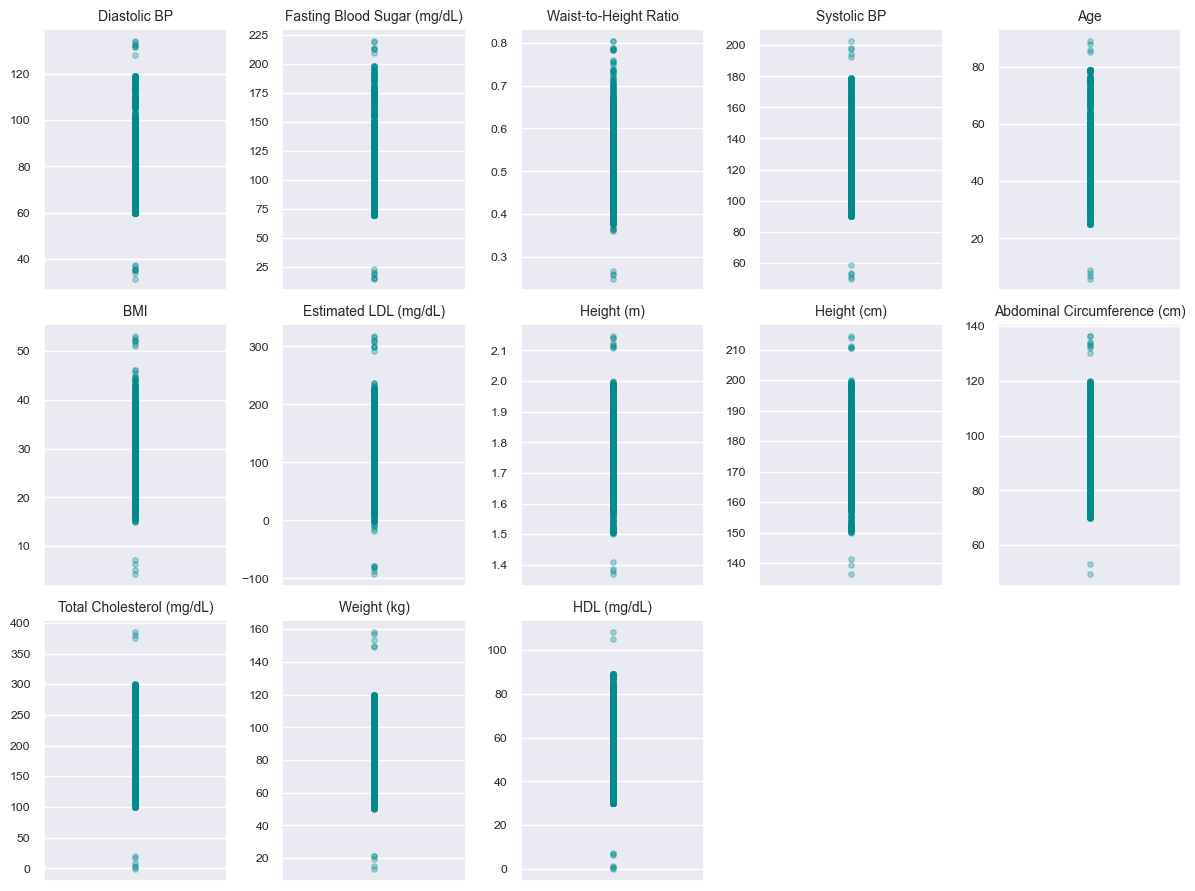

In [576]:
columnas = ['Diastolic BP', 'Fasting Blood Sugar (mg/dL)', 'Waist-to-Height Ratio', 'Systolic BP', 'Age', 'BMI', 'Estimated LDL (mg/dL)',
            'Height (m)', 'Height (cm)', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'Weight (kg)', 'HDL (mg/dL)']
fig, axes = plt.subplots(3, 5, figsize=(12, 9))
axes = axes.flatten()

for i, columna in enumerate(columnas):
    datos = data[columna].dropna()

    x = np.zeros_like(datos)
    
    axes[i].scatter(x, datos, alpha=0.3, s=15, color='darkcyan')
    
    axes[i].set_title(columna, fontsize=10)
    axes[i].set_xticks([])
    axes[i].set_xlim(-0.2, 0.2)
for j in range(len(columnas), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Según los resultados de las gráficas se observan grupos de valores atípicos lejanos de la distribución de los datos, estos valores inviables tienen efectos negativos en un modelo de regresión. Por ejemplo podemos ver que los pesos menores a 30 kg son imposibles para personas adultas de más de 170 cm de estatura, pesos de más de 140kg imposibles para BMI menores a 40, alturas en centimetros que no corresponden a la medición en metros o edades menores a 10 años imposibles para personas de más de 60 kg de peso.

In [577]:
data[data['Weight (kg)'] < 30]

,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
1317,0,38.0,21.038,1.820,22.600,NaN,165.0,56.0,137.0,1,0,1,1,182.000,0.541,113.0,94.0,3,79.0,13.470
291,1,37.0,15.036,1.870,25.900,87.600,252.0,79.0,133.0,1,1,2,1,187.000,0.468,113.0,75.0,0,143.0,17.870
1041,1,68.0,19.578,1.995,29.507,103.497,134.0,45.0,175.0,1,0,0,0,199.548,0.519,128.0,88.0,2,59.0,14.981
1579,0,40.0,21.316,1.900,24.300,NaN,216.0,61.0,146.0,0,0,2,0,190.000,0.380,90.0,72.0,0,125.0,13.680
1233,1,56.0,13.261,1.730,33.400,93.800,208.0,61.0,79.0,0,0,1,0,173.000,0.542,145.0,79.0,3,117.0,18.090


In [578]:
data[data['Weight (kg)'] > 140]


,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
1257,1,41.0,158.523,1.700,22.500,75.200,190.0,33.0,90.0,1,1,0,1,170.000,0.442,139.0,60.0,2,127.0,17.250
223,1,60.0,153.556,1.620,NaN,87.200,174.0,71.0,94.0,0,1,0,0,162.000,0.538,141.0,70.0,3,73.0,17.890
1366,1,32.0,157.164,1.898,36.837,72.410,233.0,52.0,84.0,0,0,2,1,189.815,0.381,125.0,NaN,3,151.0,18.277
586,1,35.0,149.335,1.780,NaN,119.672,173.0,60.0,187.0,0,1,2,1,177.996,0.672,113.0,65.0,0,83.0,18.323
646,1,45.0,149.877,1.616,39.633,109.352,256.0,75.0,160.0,0,1,2,1,161.584,0.677,175.0,98.0,3,151.0,23.797


In [579]:
data[data['Age'] < 10]


,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
45,0,6.0,69.769,1.696,22.060,74.184,197.0,65.0,151.0,1,0,0,0,169.560,0.438,120.0,76.0,1,NaN,14.352
331,0,9.0,87.055,1.527,23.245,96.493,132.0,80.0,188.0,1,0,0,0,152.679,0.632,103.0,72.0,0,22.0,12.439
1553,0,7.0,98.700,1.630,37.100,89.700,158.0,64.0,131.0,1,1,1,1,163.000,0.550,139.0,93.0,2,64.0,19.530
1172,1,8.0,112.520,1.520,21.988,106.120,228.0,40.0,91.0,0,1,0,1,152.020,0.698,117.0,96.0,3,158.0,16.808


In [580]:
data[data['Height (cm)'] > 200]

,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
130,0,33.0,118.300,1.690,41.400,72.10,171.0,44.0,145.0,0,0,1,0,210.554,0.427,116.0,93.0,3,97.0,17.500
1604,1,58.0,69.000,1.870,19.700,77.50,184.0,45.0,75.0,0,1,0,1,210.981,0.414,107.0,88.0,2,109.0,14.970
1084,0,55.0,88.834,1.665,27.856,91.37,106.0,NaN,87.0,1,0,0,0,210.624,NaN,120.0,75.0,1,39.0,13.691
608,1,46.0,88.100,1.630,33.200,98.70,166.0,78.0,103.0,1,1,0,1,213.920,0.606,95.0,81.0,2,58.0,16.710
433,1,57.0,100.800,1.840,29.800,88.40,102.0,33.0,128.0,1,1,2,0,214.394,0.480,110.0,78.0,0,39.0,15.500
1277,0,37.0,78.100,1.850,22.800,74.20,118.0,70.0,72.0,0,1,1,0,211.127,0.401,100.0,76.0,0,18.0,13.920


Por esta razón establecemos rangos razonables para los datos reemplazando los valores atípicos por fuera de estos rangos por `NaN` para aplicar estrategias de imputación posteriormente.

In [581]:
rangos = {
    'Diastolic BP': (40, 125),
    'Systolic BP': (80, 190),
    'Fasting Blood Sugar (mg/dL)': (60, 200),
    'Total Cholesterol (mg/dL)': (80, 320),
    'HDL (mg/dL)': (20, 100),
    'Estimated LDL (mg/dL)': (0, 250),
    'BMI': (15, 50),
    'Weight (kg)': (30, 140),
    'Height (m)': (1.45, 2),
    'Height (cm)': (145, 200),
    'Abdominal Circumference (cm)': (60, 130),
    'Waist-to-Height Ratio': (0.35, 0.8),
    'Age': (18, 100)
}
for col, (min_val, max_val) in rangos.items():
    if col in data.columns:
        data.loc[
            (data[col] <= min_val) | (data[col] >= max_val),
            col
        ] = np.nan
data.describe()

,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score
count,1298.000000,1236.000000,1227.000000,1241.000000,1243.000000,1243.000000,1234.000000,1224.000000,1240.000000,1298.000000,1298.000000,1298.000000,1298.000000,1233.000000,1230.000000,1235.000000,1228.000000,1298.000000,1227.000000,1298.000000
mean,0.503852,47.262136,86.198337,1.755085,28.557304,91.758523,198.984603,56.253268,117.066935,0.510015,0.501541,1.020031,0.489985,175.518969,0.525837,125.824291,82.981270,1.966102,112.840261,16.967587
std,0.500178,12.648313,20.980157,0.113150,7.056570,12.839031,57.519408,16.136009,30.459084,0.500092,0.500190,0.816880,0.500092,11.309207,0.083041,22.105700,14.819714,1.119157,57.653778,2.499918
min,0.000000,25.000000,50.100000,1.502000,15.100000,70.000000,100.000000,30.000000,70.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.360000,90.000000,60.000000,0.000000,1.000000,10.530000
25%,0.000000,37.000000,67.350000,1.668000,22.680500,80.544500,151.000000,42.000000,92.000000,0.000000,0.000000,0.000000,0.000000,166.984000,0.458250,108.000000,71.000000,1.000000,63.000000,15.170000
50%,1.000000,47.000000,87.400000,1.760000,28.300000,91.500000,197.000000,56.000000,115.000000,1.000000,1.000000,1.000000,0.000000,176.000000,0.522000,125.000000,82.000000,2.000000,111.000000,16.899000
75%,1.000000,56.000000,105.050000,1.846000,34.152000,102.286000,250.000000,70.000000,138.000000,1.000000,1.000000,2.000000,1.000000,184.449000,0.583750,141.000000,94.000000,3.000000,159.000000,18.671250
max,1.000000,89.000000,120.000000,1.998000,46.200000,119.996000,300.000000,89.000000,198.000000,1.000000,1.000000,2.000000,1.000000,199.960000,0.787000,179.000000,119.000000,3.000000,237.000000,24.170000


---
<a id="3"></a>
## Transformación de los datos

<a id="3_1"></a>
### Completitud e Imputación
Ahora debe observarse el nivel de completitud de las columnas restantes y en base a esto decidir la estrategia de imputación sobre los datos faltantes.

Inicialmente vamos a eliminar las entradas que tengan datos faltantes en *CVD Risk Score* la cual es nuestra variable a predecir.


In [582]:
print("CVD Risk Score faltantes: ", data['CVD Risk Score'].isnull().sum())
data = data.dropna(subset=['CVD Risk Score'])

CVD Risk Score faltantes:  0


In [583]:
((data.isnull().sum()/data.shape[0])).sort_values(ascending=False)

HDL (mg/dL)                     0.057011
Weight (kg)                     0.054700
Estimated LDL (mg/dL)           0.054700
Diastolic BP                    0.053929
Waist-to-Height Ratio           0.052388
Height (cm)                     0.050077
Total Cholesterol (mg/dL)       0.049307
Systolic BP                     0.048536
Age                             0.047766
Fasting Blood Sugar (mg/dL)     0.044684
Height (m)                      0.043914
Abdominal Circumference (cm)    0.042373
BMI                             0.042373
Sex                             0.000000
Smoking Status                  0.000000
Diabetes Status                 0.000000
Physical Activity Level         0.000000
Family History of CVD           0.000000
Blood Pressure Category         0.000000
CVD Risk Score                  0.000000
dtype: float64

Cómo se puede observar todas las variables tienen un nivel de completitud de al menos 94%, por lo que no es conveniente eliminar descriptores y se prefiere aplicar estrategias de imputación.
Para cada una de las variables faltantes se buscan variables correlacionadas que puedan ayudar a predecir los valores faltantes, para esto se realiza una matriz de correlación.

<Axes: >

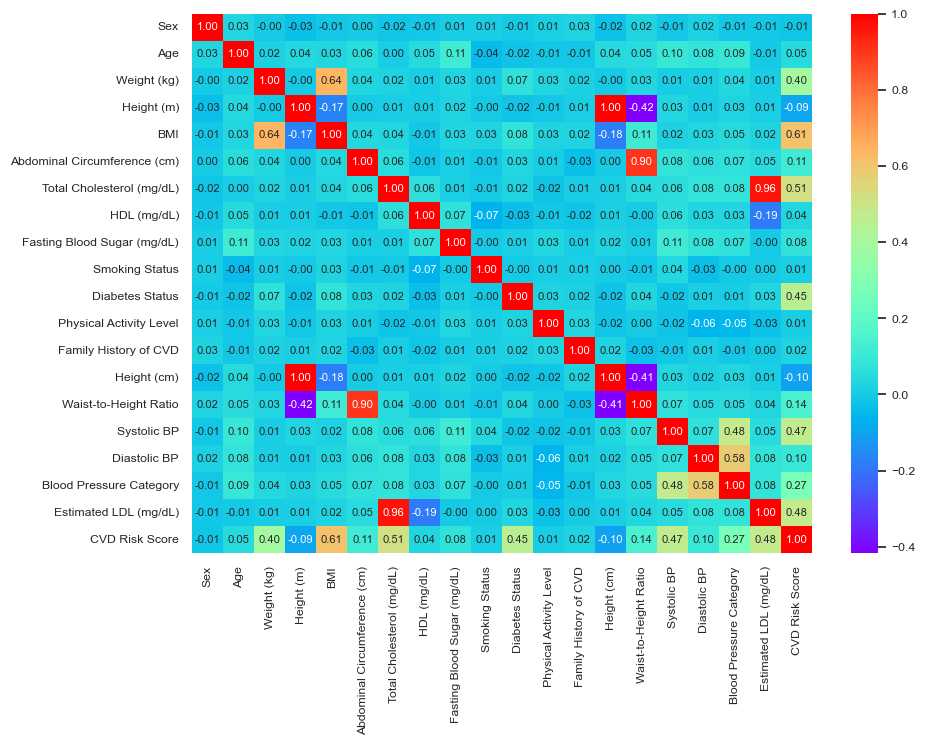

In [584]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_theme(font_scale=0.8)
sns.heatmap(data.corr(), ax=ax, cmap='rainbow', annot=True, fmt='.2f', annot_kws={"size": 8})

Con respecto a las variables con valores faltantes se pueden establecer las siguientes relaciones de colinealidad:
* *Waist-to-Height Ratio* <--> *Abdominal Circumference*
* *Total Cholesterol* <--> *Estimated LDL*
* *Height (cm)* <--> *Height (m)*

Las demás variables deben ser imputadas independientemente, para esto observaremos la distribución de cada una de ellas.

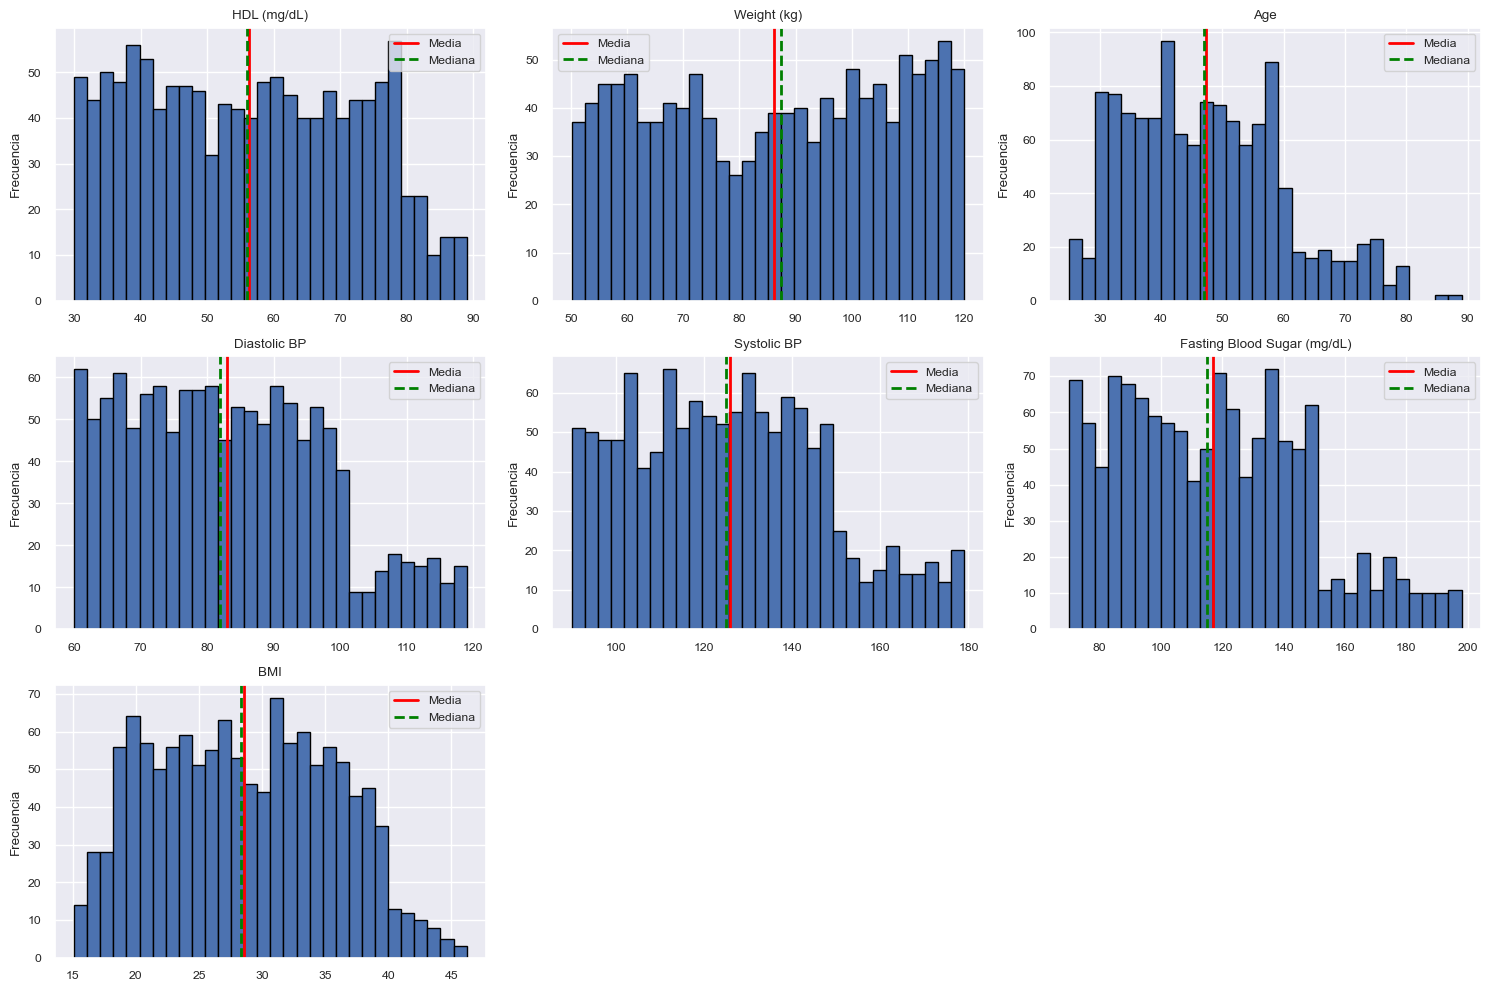

In [585]:
columnas = ['HDL (mg/dL)', 'Weight (kg)', 'Age', 'Diastolic BP', 'Systolic BP', 'Fasting Blood Sugar (mg/dL)', 'BMI']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, columna in enumerate(columnas):
    datos = data[columna].dropna()
    axes[i].hist(
        datos,
        bins=30,
        edgecolor='black'
    )
    media = datos.mean()
    mediana = datos.median()
    axes[i].axvline(
        media,
        linestyle='-',
        linewidth=2,
        label='Media',
        color='red'
    )
    axes[i].axvline(
        mediana,
        linestyle='--',
        linewidth=2,
        label='Mediana',
        color='green'
    )
    axes[i].set_title(columna)
    axes[i].set_ylabel('Frecuencia')
    axes[i].legend()

for j in range(len(columnas), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Dado que en todas las distribuciones se observa una tendencia hacia la media y mediana y dado que estas dos medidas se encuentran muy cercanas entre sí entre todas las distribuciones, se decidió imputar por la mediana a las variables enteras (*Age*, *Diastolic BP*, *Systolic BP*, *HDL* y *Fasting Blood Sugar*) y por la media a las variables flotantes (*Weight* y *BMI*).

In [586]:
median_columns = ['Age', 'Diastolic BP', 'Systolic BP', 'Fasting Blood Sugar (mg/dL)', 'HDL (mg/dL)']
mean_columns = ['Weight (kg)', 'BMI']

data[median_columns] = data[median_columns].fillna(data[median_columns].median())
data[mean_columns] = data[mean_columns].fillna(data[mean_columns].mean())

Después de la imputación simple de estas variables independientes podemos imputar por regresión a las variables correlacionadas mencionadas anteriormente.

In [587]:
# Waist to height ratio
temp_abdominal = data['Abdominal Circumference (cm)'].fillna(data['Abdominal Circumference (cm)'].mean())
k = (data['Waist-to-Height Ratio'] / temp_abdominal).dropna().median()
data['Waist-to-Height Ratio'] = data['Waist-to-Height Ratio'].fillna(k * temp_abdominal)

# Abdominal circumference
k = (data['Abdominal Circumference (cm)'] / data['Waist-to-Height Ratio']).dropna().median()
data['Abdominal Circumference (cm)'] = data['Abdominal Circumference (cm)'].fillna(k * data['Waist-to-Height Ratio'])

# Total cholesterol
temp_ldl = data['Estimated LDL (mg/dL)'].fillna(data['Estimated LDL (mg/dL)'].median())
k = (data['Total Cholesterol (mg/dL)'] / temp_ldl).dropna().median()
data['Total Cholesterol (mg/dL)'] = data['Total Cholesterol (mg/dL)'].fillna(k * temp_ldl)

# Estimated LDL
k = (data['Estimated LDL (mg/dL)'] / data['Total Cholesterol (mg/dL)']).dropna().median()
data['Estimated LDL (mg/dL)'] = data['Estimated LDL (mg/dL)'].fillna(k * data['Total Cholesterol (mg/dL)'])

# Height (cm)
temp_height_m = data['Height (m)'].fillna(data['Height (m)'].median())
data['Height (cm)'] = data['Height (cm)'].fillna(temp_height_m * 100)

#height (m)
data['Height (m)'] = data['Height (m)'].fillna(data['Height (cm)'] / 100)

Con esto completamos el proceso de imputación y observamos que no existen más valores faltantes.

In [588]:
((data.isnull().sum()/data.shape[0])).sort_values(ascending=False)

Sex                             0.0
Age                             0.0
Weight (kg)                     0.0
Height (m)                      0.0
BMI                             0.0
Abdominal Circumference (cm)    0.0
Total Cholesterol (mg/dL)       0.0
HDL (mg/dL)                     0.0
Fasting Blood Sugar (mg/dL)     0.0
Smoking Status                  0.0
Diabetes Status                 0.0
Physical Activity Level         0.0
Family History of CVD           0.0
Height (cm)                     0.0
Waist-to-Height Ratio           0.0
Systolic BP                     0.0
Diastolic BP                    0.0
Blood Pressure Category         0.0
Estimated LDL (mg/dL)           0.0
CVD Risk Score                  0.0
dtype: float64

### Multicolinealidad

Después del proceso de imputación graficaremos de nuevo la matriz de correlación de los datos, en esta matriz será importante observar las columnas que brinden información redundante o no correlacionada con la columna objetivo, *CVD Risk Score*.

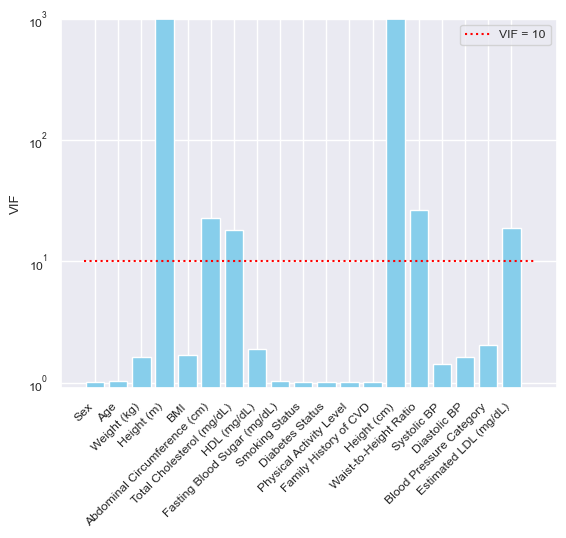

In [589]:
# VIF score
def plot_vif(data, y_max = 12, scale = None):
    X = add_constant(data.drop(columns=['CVD Risk Score']))
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.iloc[1:]
    plt.bar(vif['Variable'], vif['VIF'], color='skyblue')
    plt.hlines(10, -0.5, len(vif), colors='red', linestyles='dotted', label='VIF = 10')
    if scale == 'log': 
        plt.yscale('log', base = 10)
        plt.ylim(0.9, y_max)
    else:
        plt.ylim(0, y_max)
    plt.ylabel('VIF')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.show()
plot_vif(data, y_max=1000, scale='log')

A partir de los datos observados podemos afirmar que existen variables con alta multicolinealidad por lo que pueden estar brindando información redundante que puede llegar a confundir al modelo. Por lo tanto se deciden eliminar las variables *Height (cm)*, *Waist-to-Height Ratio* y *Estimated LDL*. 

Además se puede observar una correlación moderada de *Blood Pressure Category* con *Systolic BP* y *Diastolic BP*, sin embargo decidimos eliminar la columna *Blood Pressure Category* puesto que depende directamente de las otras dos columnas y que el no tener un nivel alto de colinealidad se explica por la separación de la variable en rangos.

Graficamos de nuevo el índice VIF para verificar que la multicolinealidad ha desaparecido.

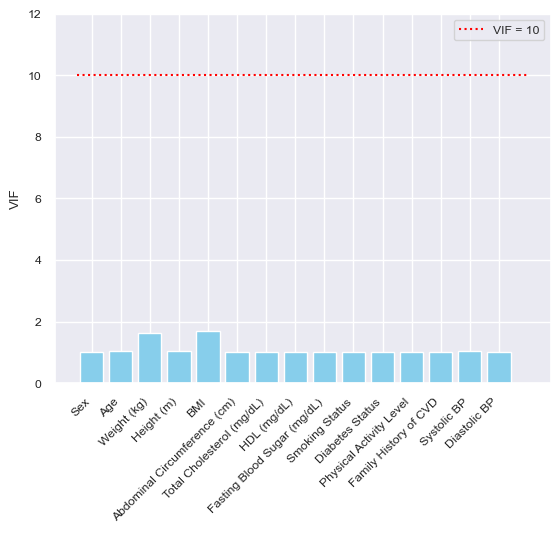

In [590]:
data.drop(columns=['Height (cm)', 'Waist-to-Height Ratio', 'Estimated LDL (mg/dL)', 'Blood Pressure Category'], inplace=True)
plot_vif(data)

<a id="3_3"></a>
### Correlación con la variable objetivo


In [591]:
corr = data.corr()['CVD Risk Score'].drop('CVD Risk Score').sort_values(ascending=False)
print(corr)

BMI                             0.596007
Total Cholesterol (mg/dL)       0.494664
Systolic BP                     0.455009
Diabetes Status                 0.452277
Weight (kg)                     0.386981
Abdominal Circumference (cm)    0.112595
Diastolic BP                    0.092916
Fasting Blood Sugar (mg/dL)     0.074249
Age                             0.047455
HDL (mg/dL)                     0.035321
Family History of CVD           0.022383
Smoking Status                  0.012915
Physical Activity Level         0.005436
Sex                            -0.013058
Height (m)                     -0.099648
Name: CVD Risk Score, dtype: float64


En cuanto a la correlación de las variables con la columna a predecir, se observa que las variables *Sex*, *Smoking Status*, *Physical Activity Level* y *Family History of CVD* tienen una baja correlación con *CVD Risk Score*, sin embargo son variables que a priori tienen un efecto sobre el riesgo de enfermedades cardiovasculares; por lo tanto se tomó la decisión de construir dos modelos, el primero con todas las variables que se tienen hasta el momento y el segundo eliminando estas variables que no muestran correlación con la variable a predecir.

In [592]:
data1 = data.copy()
data2 = data.copy()
data2 = data2.drop(columns=['Sex', 'Smoking Status', 'Physical Activity Level', 'Family History of CVD'])

### Escalado de los datos